# Homework Assignment 8

In [ ]:
# install required libraries
!pip install leafmap
!pip install keplergl
!pip install geopy
!pip install geopandas
!pip install plotly_express
!pip install turicreate

**Question 1:** Select a book or a movie's subtitle, and find the locations that appear in the book/movie. Then, draw these locations on a map (at least 10 locations) (30pt). Connect the discovered locations with lines according to their order of appearance
in the book. For example, if location B appeared immediately after location A, then draw a line connecting locations A and B (20pt).

In [12]:
# improt regular expressions and spacy
import re
import spacy
# !python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

In [13]:
# create directories
!mkdir './datasets'
!mkdir './datasets/into-the-wild'

# download into the wild movie's subtitles
!wget https://yifysubtitles.org/subtitle/into-the-wild-2007-english-yify-101284.zip -O ./datasets/into-the-wild/into-the-wild.zip
!unzip ./datasets/into-the-wild/*.zip -d ./datasets/into-the-wild

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/into-the-wild’: File exists
--2021-12-16 11:50:08--  https://yifysubtitles.org/subtitle/into-the-wild-2007-english-yify-101284.zip
Resolving yifysubtitles.org (yifysubtitles.org)... 172.64.103.3, 172.64.102.3, 2606:4700:e0::ac40:6603, ...
Connecting to yifysubtitles.org (yifysubtitles.org)|172.64.103.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34071 (33K) [application/zip]
Saving to: ‘./datasets/into-the-wild/into-the-wild.zip’

./datasets/into-the 100%[===================>]  33.27K  --.-KB/s    in 0.001s  

2021-12-16 11:50:09 (41.9 MB/s) - ‘./datasets/into-the-wild/into-the-wild.zip’ saved [34071/34071]

Archive:  ./datasets/into-the-wild/into-the-wild.zip
yifysubtitles.org
replace ./datasets/into-the-wild/Into.the.Wild.2007.720p.BluRay.x264.[YTS.MX]-English.srt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./datasets/into-the-wild/Into.the.Wild.

In [14]:
path = './datasets/into-the-wild/Into.the.Wild.2007.720p.BluRay.x264.[YTS.MX]-English.srt'
txt = ''

# read file, remove html tags, and get words only.
with open(path, 'r') as file:
  for line in file.readlines():
    line = re.sub(r'<.*?>', '', line) # remove html tags
    norm_line = re.findall(r"[a-zA-Z\']+", line)  # get only words
    if len(norm_line) > 0:
      txt +=' ' + ' '.join(norm_line)

txt = txt.strip()
txt

"Downloaded From www AllSubs org Mom Mom Help me What is it I wasn't dreaming Walt I didn't imagine it I heard him I heard him I heard him I heard Chris I heard him I know No I wasn't imagining it Walt No I did He's He's I heard him Billie That's about as far as I can get you All right Thank you You left all your shit on my dash Keep it Suit yourself Thanks again Hey hold on a minute Here take these They'll keep your feet dry If you make it out alive give me a call My number's inside the boots Thanks Hello Is there anybody here Guess not Two years he walks the earth No phone no pool no pets no cigarettes Ultimate freedom An extremist An aesthetic voyager whose home is the road Hey listen old man Now don't psychoanalyze me all right Shut up I'm taking you out to where we're going Where you going I told you We're going nowhere So now after two rambling years comes the final and greatest adventure The climactic battle to kill the false being within and victoriously conclude the spiritual 

In [15]:
# create set of locations using spacy 
def get_locations(txt):
    doc = nlp(txt)
    locations = [entity.text.lower().strip().replace('\n', ' ') for entity in doc.ents if entity.label_ in ["LOC", "GPE"]]
    return set(locations)

locations = get_locations(txt)

In [16]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# create dataframe with all the locations that was found 
df = pd.DataFrame({'name': list(locations)})

geolocator = Nominatim(user_agent="locations_coord")

# find if the location exists and its geo location coordinates 
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
df['location'] = df['name'].apply(geocode)
df['Longitude']    = df['location'].apply(lambda loc: loc.point[1] if loc else None)
df['Latitude']  = df['location'].apply(lambda loc: loc.point[0] if loc else None)

# remove unknown locations
df.dropna(axis = 0, inplace=True)
df

name  ...   Latitude
0             south dakota  ...  44.647176
1                   alaska  ...  64.445961
2                las vegas  ...  36.167256
3                  atlanta  ...  33.748992
4                annandale  ...  45.262743
5              slab city's  ...  46.975324
6                   marine  ...  38.786436
7            west virginia  ...  38.475841
8                    flint  ...  43.016169
9                  roswell  ...  34.023320
10        the grand canyon  ...  43.591281
11                 georgia  ...  32.329381
12              copenhagen  ...  55.686724
13                  turkey  ...  38.959759
14                  mexico  ...  23.553557
15              montebello  ...  34.015940
16                    reno  ...  39.526121
18      the colorado river  ...  30.254634
19          the salton sea  ...  38.486844
20                  regina  ...  50.448760
21              california  ...  36.701463
22                colorado  ...  38.725178
23                 okinawa  ...  26.474895
24             salton city  ...  33.296668
26            north alaska  ...  48.574030
27                   gonna  ... -33.959328
28  the gulf of california  ...  35.179412
29                   earth  ...  34.233137
30                  africa  ...  11.502434
31             los angeles  ...  34.053691

[30 rows x 4 columns]

In [17]:
import geopandas
import matplotlib.pyplot as plt

# import the world map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# create geopands dataframe with the coordinates of each location
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))
gdf

name  ...                     geometry
0             south dakota  ...  POINT (-100.34876 44.64718)
1                   alaska  ...  POINT (-149.68091 64.44596)
2                las vegas  ...  POINT (-115.14852 36.16726)
3                  atlanta  ...   POINT (-84.39026 33.74899)
4                annandale  ...   POINT (-94.12443 45.26274)
5              slab city's  ...   POINT (-71.24610 46.97532)
6                   marine  ...   POINT (-89.77759 38.78644)
7            west virginia  ...   POINT (-80.84084 38.47584)
8                    flint  ...   POINT (-83.69002 43.01617)
9                  roswell  ...   POINT (-84.36002 34.02332)
10        the grand canyon  ...   POINT (-89.76680 43.59128)
11                 georgia  ...   POINT (-83.11374 32.32938)
12              copenhagen  ...    POINT (12.57007 55.68672)
13                  turkey  ...    POINT (34.92497 38.95976)
14                  mexico  ...  POINT (-102.26752 23.55356)
15              montebello  ...  POINT (-118.11198 34.01594)
16                    reno  ...  POINT (-119.81266 39.52612)
18      the colorado river  ...   POINT (-97.66956 30.25463)
19          the salton sea  ...  POINT (-121.54459 38.48684)
20                  regina  ...  POINT (-104.61731 50.44876)
21              california  ...  POINT (-118.75600 36.70146)
22                colorado  ...  POINT (-105.60772 38.72518)
23                 okinawa  ...   POINT (127.91147 26.47489)
24             salton city  ...  POINT (-115.95854 33.29667)
26            north alaska  ...  POINT (-117.35161 48.57403)
27                   gonna  ...   POINT (23.05036 -33.95933)
28  the gulf of california  ...  POINT (-119.16007 35.17941)
29                   earth  ...  POINT (-102.41075 34.23314)
30                  africa  ...    POINT (17.75781 11.50243)
31             los angeles  ...  POINT (-118.24277 34.05369)

[30 rows x 5 columns]

In [18]:
# order locations by  their order of appearance in the movie
import operator

first_occurence = {}
for loc in gdf['name'].values:
  first_occurence[loc] = txt.lower().find(loc)
loc_order = sorted(first_occurence.items(), key=operator.itemgetter(1), reverse=False)
loc_order

[('earth', 566),
 ('regina', 1348),
 ('flint', 2361),
 ('georgia', 2982),
 ('gonna', 4034),
 ('africa', 5452),
 ('atlanta', 5733),
 ('annandale', 11195),
 ('alaska', 13525),
 ('roswell', 15576),
 ('california', 17285),
 ('copenhagen', 19786),
 ('los angeles', 20183),
 ('las vegas', 20215),
 ('mexico', 20538),
 ('the gulf of california', 21001),
 ('montebello', 24146),
 ("slab city's", 28432),
 ('salton city', 28597),
 ('marine', 30600),
 ('reno', 31129),
 ('south dakota', 32362),
 ('west virginia', 34131),
 ('the salton sea', 35199),
 ('okinawa', 35410),
 ('turkey', 35871),
 ('the colorado river', 36660),
 ('colorado', 36664),
 ('the grand canyon', 36704),
 ('north alaska', 36911)]

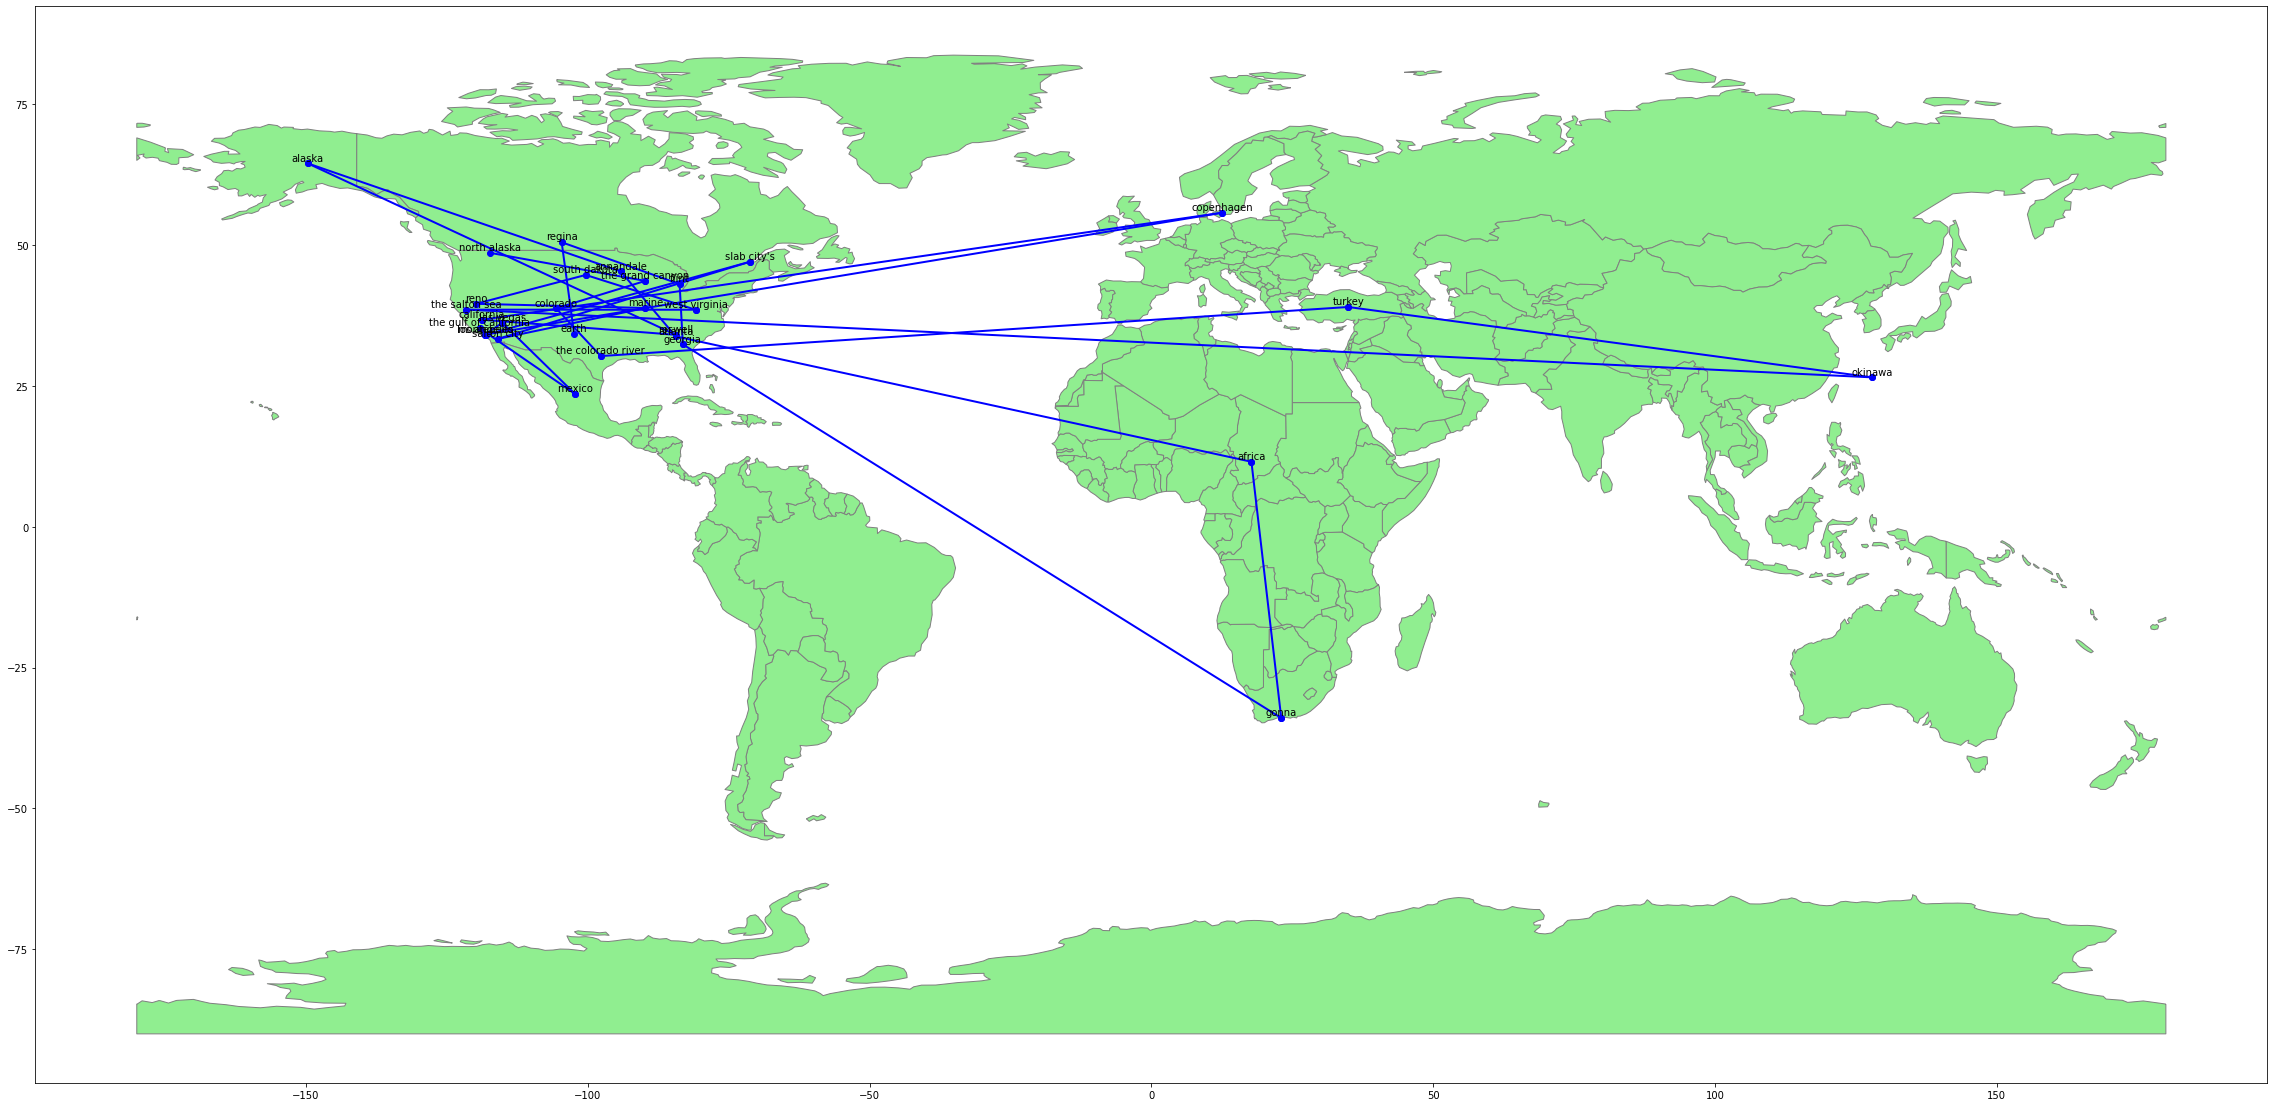

In [19]:
# plot the world map
ax = world.plot(color='lightgreen', edgecolor='gray',figsize=(40,40))
# add locations' marker map the map
gdf.plot(ax=ax, marker='o', color='red', markersize=6);

# adding labels o
for idx, row in gdf.iterrows():
    pt = row['geometry']
    plt.annotate(s=row['name'], xy=(pt.x, pt.y+0.5),
                 horizontalalignment='center', fontsize=10,color="black")

# adding lines
for index in range(len(loc_order)-1):
  first_loc = gdf[gdf['name'] == loc_order[index][0]]
  second_loc = gdf[gdf['name'] == loc_order[index + 1][0]]
  first_lon, first_lan = float(first_loc['geometry'].x), float(first_loc['geometry'].y)
  second_lon, second_lan = float(second_loc['geometry'].x), float(second_loc['geometry'].y)
  plt.plot([first_lon, second_lon], [first_lan, second_lan], color='blue', linewidth=2, marker='o')

**Question 2:** Select a country's' statistic from the [World Development Indicators dataset](https://www.kaggle.com/worldbank/world-development-indicators) (Please notice there are several files in the dataset, such as _Indicators.csv_).
Then, create a choropleth map displaying how the selected statistics changed over time (15pt) 
    
**Bonus:** Create a short animation that displays how the chosen statistics changed over time (15pt)

In [20]:
import json
import os

!mkdir /root/.kaggle/

# Installing the Kaggle package
api_token = {"username":"amitdamri","key":"a076ad6676498fde930f6aacbda924c4"}

# creating kaggle.json file with the personal API-Key details 
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [21]:
import kaggle

# create directories
!mkdir ./datasets
!mkdir ./datasets/WDI

# download dataset from kaggle
!kaggle datasets download -d kaggle/world-development-indicators -p ./datasets/WDI
!unzip ./datasets/WDI/*.zip -d ./datasets/WDI

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/WDI’: File exists
world-development-indicators.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./datasets/WDI/world-development-indicators.zip
replace ./datasets/WDI/Country.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./datasets/WDI/Country.csv  
replace ./datasets/WDI/CountryNotes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./datasets/WDI/CountryNotes.csv  
replace ./datasets/WDI/Footnotes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./datasets/WDI/Footnotes.csv  
replace ./datasets/WDI/Indicators.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./datasets/WDI/Indicators.csv  y

replace ./datasets/WDI/Series.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: ./datasets/WDI/Series.csv  
replace ./datasets/WDI/SeriesNotes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./datas

I chose the Alternative and nuclear energy statistic.

In [22]:
df = pd.read_csv('./datasets/WDI/Indicators.csv')
# get only the chosen statistic 
df_energy = df[df['IndicatorCode'] == 'EG.USE.COMM.CL.ZS']
df_energy

CountryName CountryCode  ...  Year      Value
161                 Central Europe and the Baltics         CEB  ...  1960   0.100326
233        East Asia & Pacific (all income levels)         EAS  ...  1960   5.333055
477                                      Euro area         EMU  ...  1960   3.813289
596      Europe & Central Asia (all income levels)         ECS  ...  1960   3.501110
705        Europe & Central Asia (developing only)         ECA  ...  1960   0.806109
...                                            ...         ...  ...   ...        ...
5514982                                     Sweden         SWE  ...  2013  48.502343
5515645                                Switzerland         CHE  ...  2013  39.446386
5522530                                     Turkey         TUR  ...  2013   7.924006
5526645                             United Kingdom         GBR  ...  2013  11.298393
5527290                              United States         USA  ...  2013  12.060389

[7021 rows x 6 columns]

In [23]:
import plotly_express as px

# plot a choropleth map displaying how the selected statistics (Alternative and nuclear energy) changed over time for each country
px.choropleth(df_energy, locations='CountryCode', color='Value', animation_frame='Year', 
              hover_name="CountryName", color_continuous_scale=px.colors.sequential.Plasma)

**Question 3:** Select a request type from [San Francisco 311 dataset](https://www.kaggle.com/datasf/case-data-from-san-francisco-311).
Create an interactive map that somehow presents in which areas this request occurs the most (35pt).

In [24]:
import turicreate as tc
import turicreate.aggregate as agg

In [25]:
# create dir and download dataset
!mkdir ./datasets/SanFran311

!kaggle datasets download -d datasf/case-data-from-san-francisco-311 -p ./datasets/SanFran311
!unzip ./datasets/SanFran311/*.zip -d ./datasets/SanFran311s

mkdir: cannot create directory ‘./datasets/SanFran311’: File exists
case-data-from-san-francisco-311.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./datasets/SanFran311/case-data-from-san-francisco-311.zip
  inflating: ./datasets/SanFran311s/Case_Data_from_San_Francisco_311__SF311.csv  
  inflating: ./datasets/SanFran311s/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.dbf  
  inflating: ./datasets/SanFran311s/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.prj  
  inflating: ./datasets/SanFran311s/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.shp  
  inflating: ./datasets/SanFran311s/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.shx  
  inflating: ./datasets/SanFran311s/Shapefiles (2)/Supervisor Districts as of April 2012/geo_export_38fd3153-0303-488e-9f3c-0f81e8e00115.dbf  
  infl

I chose the Sidewalk Cleaning request

In [26]:
# load and filter data
sf = tc.SFrame.read_csv("./datasets/SanFran311/Case_Data_from_San_Francisco_311__SF311.csv")
sf_sidewalk_clean = sf[sf['Request Type'] == "Sidewalk_Cleaning"]

Read 100 lines. Lines per second: 39.9805

Finished parsing file /content/datasets/SanFran311/Case_Data_from_San_Francisco_311__SF311.csv

Parsing completed. Parsed 100 lines in 2.50225 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,str,str,str,str,str,str,str,str,int,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 733045 lines. Lines per second: 130906

Unexpected characters after last column. "Abandoned Vehicle - Car4door"
Parse failed at token ending at: 
	s Work Queue,Abandoned Vehicle,Abandoned Vehicle - Car4door,^Gray - Volkswagen -  - 7MJV079,Intersection of 2
Successfully parsed 16 tokens: 
	0: 5526685
	1: 02/02/2016 ... 5:55:47 AM
	2: 02/03/2016 ... 1:21:40 AM
	3: 02/03/2016 ... 1:21:40 AM
	4: Closed
	5: "Case Reso ... 1256715196
	6: -122.391840449142)"
	7: Voice In
	8: 5698025
	9: 03/24/2016 ... 8:34:48 PM
	10: 03/29/2016 ... 8:25:01 AM
	11: 3
	12: Closed
	13: DPT Abando ...       #229
	14: DPT Abando ... Work Queue
	15: Abandoned Vehicle

Unable to interpret "Environmental Health-DPH" as a integer
Parse failed at token ending at: 
	 Environmental Health-DPH^
Successfully parsed 0 tokens:

Unable to interpret "(415)-252-380"" as a integer
Parse failed at token ending at: 
	 (415)-252-380",^DPH - Environmental Health - G,General Requests,
Successfully parsed 0 tokens:

Unable to interpret "Environmental Health-DPH" as a integer
Parse failed at token ending at: 
	 Environmental Health-DPH^
Successfully parsed 0 tokens:

Unable to interpret "(415)-252-380"" as a integer
Parse failed at token ending at: 
	 (415)-252-380",^DPH - Environmental Health - G,Noise Report,mech
Successfully parsed 0 tokens:

Unexpected characters after last column. "DPW Ops Queue"
Parse failed at token ending at: 
	:00:36 AM,Closed,Case Resolved - duplicate sr,DPW Ops Queue,^Street and Sidewalk Cleaning,Illegal Encampment,
Successfully parsed 16 tokens: 
	0: 415
	1: DPH - Envi ... Health - G
	2: Street and ... k Cleaning
	3: Hazardous Materials
	4: Needles
	5: Intersecti ... and 8TH ST
	6: 10
	7: Showplace Square
	8: (37.767300 ... 428647996)
	9: Voice In
	10: 5698219
	11: 3
	12: 03/25/2016 ... 7:00:36 AM
	13: 03/25/2016 ... 7:00:36 AM
	14: Closed
	15: Case Resol ... plicate sr

Unexpected characters after last column. "DPW Ops Queue"
Parse failed at token ending at: 
	/2016 01:00:00 AM,Closed,Case Resolved - done,DPW Ops Queue,^Street and Sidewalk Cleaning,Hazardous Materials
Successfully parsed 16 tokens: 
	0: 415
	1: DPH - Envi ... Health - G
	2: Street and ... k Cleaning
	3: Hazardous Materials
	4: Needles
	5: Intersecti ...  HOWARD ST
	6: 6
	7: South of Market
	8: (37.773100 ... 561380814)
	9: Voice In
	10: 5698609
	11: 3
	12: 03/29/2016 ... 1:00:00 AM
	13: 03/29/2016 ... 1:00:00 AM
	14: Closed
	15: Case Resolved - done

Unable to interpret "Environmental Health-DPH" as a integer
Parse failed at token ending at: 
	 Environmental Health-DPH^
Successfully parsed 0 tokens:

Unable to interpret "(415)-252-380"" as a integer
Parse failed at token ending at: 
	 (415)-252-380",^DPH - Environmental Health - G,Noise Report,garb
Successfully parsed 0 tokens:

Unable to interpret "Environmental Health-DPH" as a integer
Parse failed at token ending at: 
	 Environmental Health-DPH^
Successfully parsed 0 tokens:

16596 lines failed to parse correctly

Finished parsing file /content/datasets/SanFran311/Case_Data_from_San_Francisco_311__SF311.csv

Parsing completed. Parsed 1161482 lines in 9.55586 secs.

In [27]:
# given a string of point, extract x,y values
def get_point(point):
  # remove bracket
  norm_point = point.replace('(', '')
  norm_point = norm_point.replace(')', '')
  #split into x y coordinates
  x_y = norm_point.split(', ')
  return x_y

# extract the latitude and longitude for each location
sf_sidewalk_clean['Latitude'] = sf_sidewalk_clean['Point'].apply(lambda p: round(float(get_point(p)[0]),4))
sf_sidewalk_clean['Longitude'] = sf_sidewalk_clean['Point'].apply(lambda p: round(float(get_point(p)[1]),4))
sf_sidewalk_clean.dropna()
# count for each location the number of requests
g = sf_sidewalk_clean.groupby(['Latitude', 'Longitude'], {'Count': agg.COUNT()})
g.sort('Count', ascending=False)
g.export_csv("./san_francisco_sidewalk_cleaning_count.csv")

Using kepler.gl to create an interactive map that presents in which areas the request of side walk cleaning occurs the most

In [28]:
import leafmap.kepler as leafmap

# plot an interactive map of san francisco that presents in which areas the request of sidewalk cleaning occurs the most
m = leafmap.Map(center=[37.7621, -122.4143], zoom=12)
m.add_csv("./san_francisco_sidewalk_cleaning_count.csv", layer_name="sanfran")
m

Map(config={'version': 'v1', 'config': {'mapState': {'latitude': 37.7621, 'longitude': -122.4143, 'zoom': 12}}…